## Gesture Classification 
### Using Time Series describing the 3D acceleration history of a gesture 

### Data Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os

In [2]:
print('U1 (4) means User 1, 4th day')
os.listdir('data/')

U1 (4) means User 1, 4th day


['U1 (2)',
 'U2 (1)',
 'U3 (1)',
 'U2 (2)',
 'U1 (1)',
 'U3 (2)',
 'U7 (2)',
 '.DS_Store',
 'U4 (1)',
 'U5 (1)',
 'U6 (2)',
 'U4 (2)',
 'U8 (3)',
 'U7 (1)',
 'U6 (1)',
 'U5 (2)',
 'U7 (5)',
 'U4 (6)',
 'U8 (7)',
 'U5 (6)',
 'U6 (5)',
 'U4 (5)',
 'U8 (4)',
 'U7 (6)',
 'U6 (6)',
 'U5 (5)',
 'U1 (5)',
 'U2 (6)',
 'U3 (6)',
 'U2 (5)',
 'U1 (6)',
 'U3 (5)',
 'U2 (4)',
 'U1 (7)',
 'U3 (4)',
 'U1 (4)',
 'U2 (7)',
 'U3 (7)',
 'U8 (5)',
 'U4 (4)',
 'U7 (7)',
 'U6 (7)',
 'U5 (4)',
 'U7 (4)',
 'U8 (6)',
 'U4 (7)',
 'U5 (7)',
 'U6 (4)',
 'Readme.txt',
 'U8 (2)',
 'U4 (3)',
 'U5 (3)',
 'U7 (3)',
 'U8 (1)',
 'U6 (3)',
 'U2 (3)',
 'U3 (3)',
 'U1 (3)']

In [3]:
print("Name convention: $some prefix$1-9 means Gesture 1, Repitition no. 9")
os.listdir('data/U1 (1)/')

Name convention: $some prefix$1-9 means Gesture 1, Repitition no. 9


['A_Template_Acceleration1-9.txt',
 'A_Template_Acceleration2-10.txt',
 'A_Template_Acceleration1-8.txt',
 'A_Template_Acceleration3-8.txt',
 'A_Template_Acceleration3-9.txt',
 'A_Template_Acceleration7-9.txt',
 'A_Template_Acceleration7-8.txt',
 'A_Template_Acceleration5-8.txt',
 'A_Template_Acceleration5-9.txt',
 'A_Template_Acceleration8-3.txt',
 'A_Template_Acceleration2-8.txt',
 'A_Template_Acceleration2-9.txt',
 'A_Template_Acceleration8-2.txt',
 'A_Template_Acceleration8-10.txt',
 'A_Template_Acceleration4-10.txt',
 'A_Template_Acceleration8-1.txt',
 'A_Template_Acceleration6-10.txt',
 'A_Template_Acceleration8-5.txt',
 'A_Template_Acceleration4-8.txt',
 'A_Template_Acceleration4-9.txt',
 'A_Template_Acceleration8-4.txt',
 'A_Template_Acceleration8-6.txt',
 'A_Template_Acceleration6-9.txt',
 'A_Template_Acceleration6-8.txt',
 'A_Template_Acceleration8-7.txt',
 'A_Template_Acceleration6-5.txt',
 'A_Template_Acceleration4-7.txt',
 'A_Template_Acceleration2-1.txt',
 'A_Template_Acc

In [4]:
#Loading multiple files into a single DataFrame using pd.concat() in a loop can be very inefficient, especially when dealing with a large number of files. Better use data list

df = pd.DataFrame(columns=['X','Y','Z','Gesture','Repetition','User','Day'])
data_list = []

for user_day in os.listdir('data/'):
    if 'U' not in user_day:
        continue
    user = user_day.split(' ')[0][1]
    day = user_day.split(' ')[1][1]
    for filename in os.listdir(f'data/{user_day}/'):
        if '-' not in filename:
            continue
        df_temp = pd.read_csv(f'data/{user_day}/{filename}', header=None, delimiter=' ', names=['X','Y','Z'])
        df_temp['Gesture'] = filename.split('-')[0][-1]
        df_temp['Repetition'] = filename.split('-')[1].split('.')[0]
        df_temp['User'] = user
        df_temp['Day'] = day
        data_list.append(df_temp)

df = pd.concat(data_list, axis=0).reset_index(drop=True)

In [5]:
df.head()

,X,Y,Z,Gesture,Repetition,User,Day
0,-0.461539,-0.615385,0.08,1,9,1,2
1,-0.461539,-0.615385,0.08,1,9,1,2
2,-0.461539,-0.615385,0.08,1,9,1,2
3,-0.461539,-0.615385,0.08,1,9,1,2
4,-0.461539,-0.615385,0.08,1,9,1,2


## Problem: 
### Logistic Regression does not understand the concept of Time Series.


In [6]:
df.groupby(['User','Day','Gesture','Repetition']).count()

X    Y    Z
User Day Gesture Repetition               
1    1   1       1           148  148  148
                 10          138  138  138
                 2           164  164  164
                 3           129  129  129
                 4           153  153  153
...                          ...  ...  ...
8    7   8       5           208  208  208
                 6           209  209  209
                 7           206  206  206
                 8           188  188  188
                 9           207  207  207

[4481 rows x 3 columns]

In theory, we could stack all X,Y,Z values to one array, and create one column for each entry, so that one row corresponds to one entire time series, labeled with the corresponding gesture, day, user, and repetition index. 

However, the length of the different time series is not constant, because the different gestures take different time to complete, and some users might be faster than others. 
This means that a lot of columns would have zeros for those (imaginary) time stamps where the user does not perform an action. 

Another approach would be to extract characteristics from the different time series, and only use those as features to the ML model. Let's do this


In [7]:
df_feats = df.groupby(['User','Day','Gesture','Repetition']).agg(['mean','std','min','max']).reset_index()

In [8]:
df_feats.columns = ['User', 'Day','Gesture','Repetition', 
                    'X_mean','X_std', 'X_min', 'X_max',
                    'Y_mean', 'Y_std', 'Y_min', 'Y_max',
                    'Z_mean', 'Z_std', 'Z_min', 'Z_max']

In [9]:
df_feats.head()

,User,Day,Gesture,Repetition,X_mean,X_std,X_min,X_max,Y_mean,Y_std,Y_min,Y_max,Z_mean,Z_std,Z_min,Z_max
0,1,1,1,1,-0.433992,0.421207,-1.769231,0.346154,0.011175,0.378928,-0.576923,0.692308,0.794865,0.352909,0.20,1.56
1,1,1,1,10,-0.367893,0.320109,-0.923077,0.269231,0.030379,0.367192,-0.461539,0.807692,0.766667,0.534292,-0.20,1.64
2,1,1,1,2,-0.167917,0.342584,-0.730769,0.423077,0.096154,0.294166,-0.423077,0.500000,0.918780,0.318784,0.40,1.72
3,1,1,1,3,-0.492248,0.467296,-1.307692,0.500000,0.024150,0.314236,-0.576923,0.500000,0.729302,0.538389,-0.16,1.80
4,1,1,1,4,-0.206636,0.495147,-0.846154,0.769231,0.146053,0.396388,-0.538462,0.846154,0.777778,0.463962,-0.12,1.56


## EDA

In [10]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4481 entries, 0 to 4480
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User        4481 non-null   object 
 1   Day         4481 non-null   object 
 2   Gesture     4481 non-null   object 
 3   Repetition  4481 non-null   object 
 4   X_mean      4481 non-null   float64
 5   X_std       4479 non-null   float64
 6   X_min       4481 non-null   float64
 7   X_max       4481 non-null   float64
 8   Y_mean      4481 non-null   float64
 9   Y_std       4479 non-null   float64
 10  Y_min       4481 non-null   float64
 11  Y_max       4481 non-null   float64
 12  Z_mean      4481 non-null   float64
 13  Z_std       4479 non-null   float64
 14  Z_min       4481 non-null   float64
 15  Z_max       4481 non-null   float64
dtypes: float64(12), object(4)
memory usage: 560.2+ KB


In [11]:
df_feats = df_feats.dropna()

In [12]:
df_feats.describe()

,X_mean,X_std,X_min,X_max,Y_mean,Y_std,Y_min,Y_max,Z_mean,Z_std,Z_min,Z_max
count,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.00000,4479.000000
mean,-0.033760,0.485695,-0.895349,0.833445,0.245417,0.361701,-0.326644,0.920604,0.926069,0.588393,-0.02605,2.019486
std,0.258672,0.265266,0.586020,0.514195,0.282715,0.179254,0.328216,0.567640,0.209078,0.335493,0.58264,0.674650
min,-1.226297,0.017804,-4.230769,-0.615385,-0.452771,0.018579,-2.576923,-0.346154,-0.462609,0.000000,-2.72000,0.040000
25%,-0.130807,0.289187,-1.269231,0.461539,0.057322,0.234166,-0.538462,0.538462,0.863336,0.334499,-0.40000,1.480000
50%,0.010747,0.481407,-0.846154,0.769231,0.205556,0.336024,-0.307692,0.807692,0.952500,0.579105,-0.08000,1.960000
75%,0.114677,0.653231,-0.423077,1.153846,0.371041,0.453672,-0.115385,1.192308,1.010109,0.811310,0.44000,2.440000
max,0.920815,1.542044,0.692308,3.230769,1.855769,1.565605,1.115385,3.961539,2.755556,1.964370,1.96000,4.560000


In [13]:
df_feats.describe(include='object')

,User,Day,Gesture,Repetition
count,4479,4479,4479,4479
unique,8,7,8,11
top,1,1,3,1
freq,561,640,561,448


3    561
2    560
4    560
5    560
6    560
8    560
1    559
7    559
Name: Gesture, dtype: int64

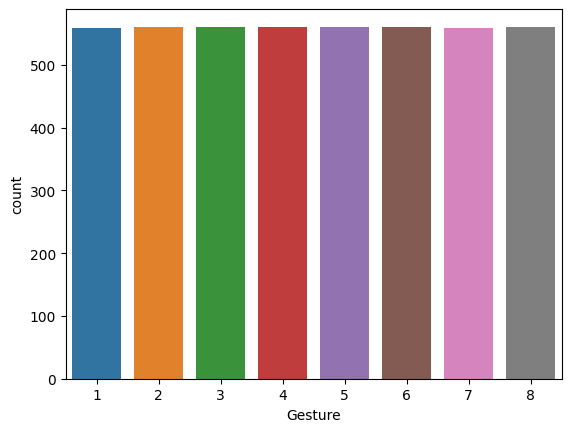

In [14]:
sns.countplot(x='Gesture', data=df_feats)
df_feats.select_dtypes(include='object')['Gesture'].value_counts()

<Axes: >

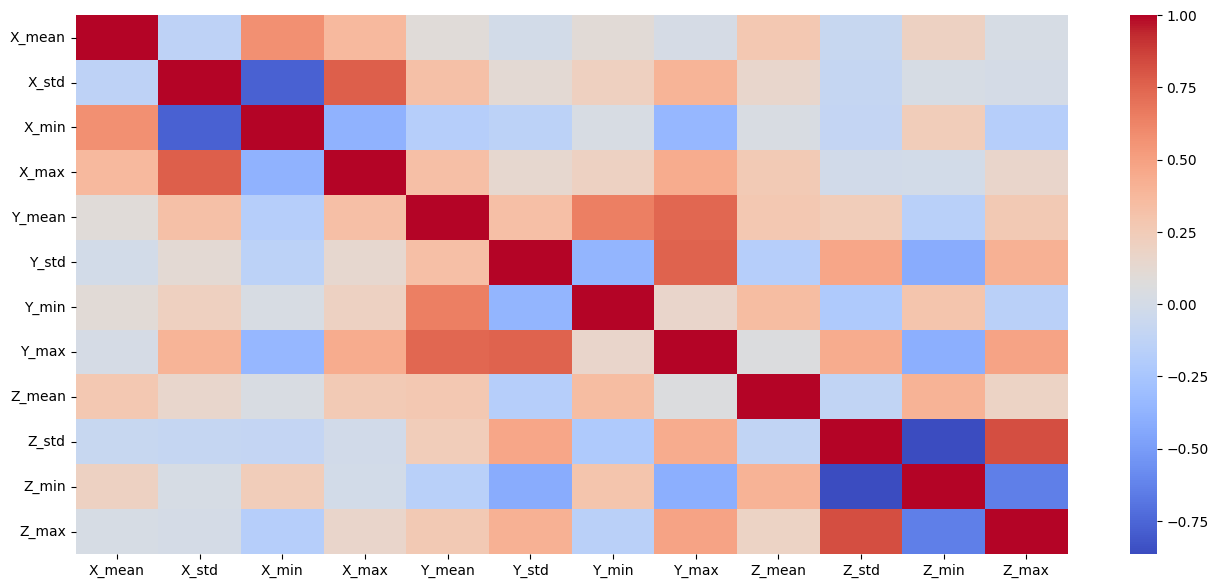

In [15]:
plt.figure(figsize=(16,7))
sns.heatmap(df_feats.corr(), annot=False, cmap='coolwarm')

<Axes: xlabel='X_mean', ylabel='Count'>

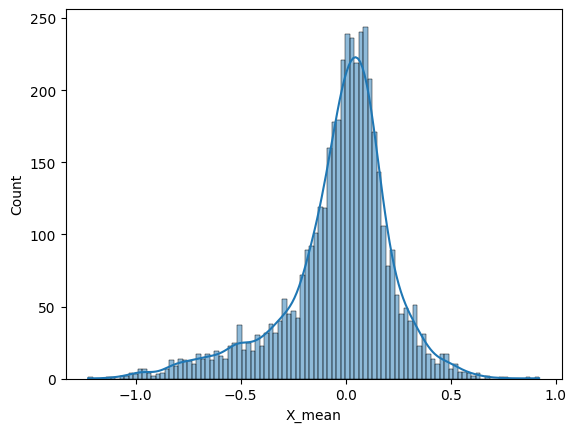

In [16]:
sns.histplot(x='X_mean', data=df_feats, bins=100, kde=True)

<Axes: xlabel='Gesture', ylabel='X_mean'>

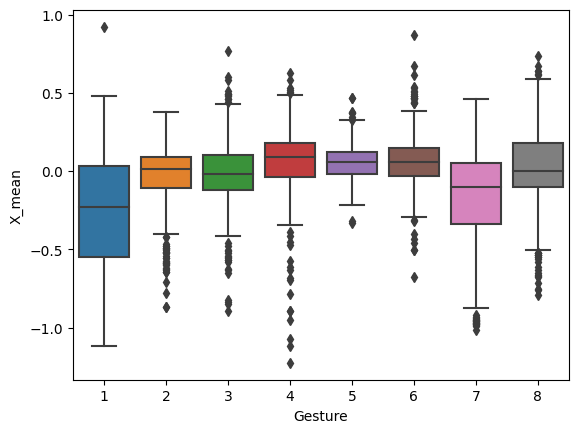

In [17]:
sns.boxplot(x='Gesture', y='X_mean', data=df_feats)

<Axes: xlabel='Gesture', ylabel='Y_mean'>

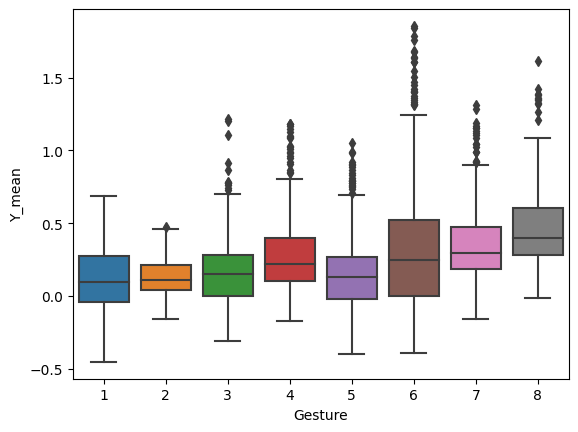

In [18]:
sns.boxplot(x='Gesture', y='Y_mean', data=df_feats)

<Axes: xlabel='Gesture', ylabel='Z_mean'>

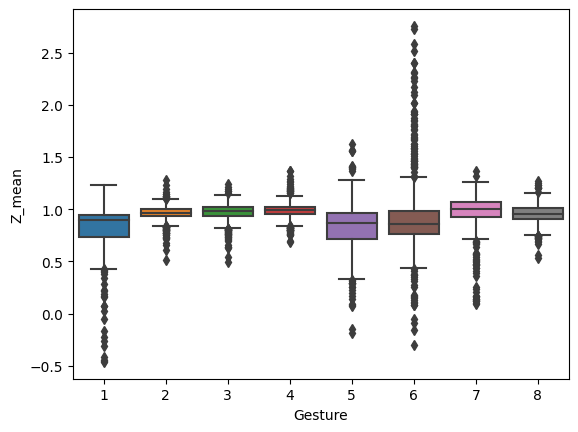

In [19]:
sns.boxplot(x='Gesture', y='Z_mean', data=df_feats)

Outliers: X_mean > 0.8, Y_mean > 1.5, Z_mean > 1.6

<Axes: xlabel='Gesture', ylabel='X_max'>

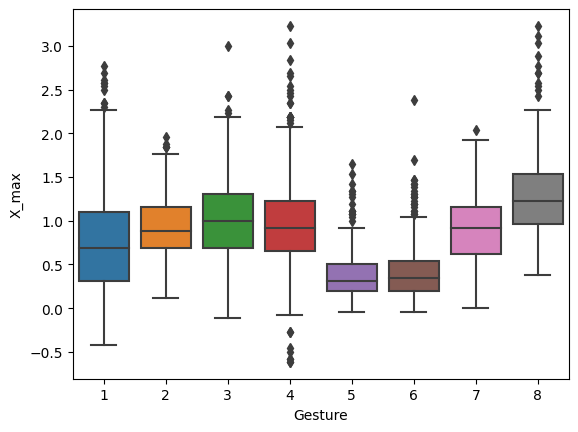

In [20]:
sns.boxplot(x='Gesture', y='X_max', data=df_feats)

<Axes: xlabel='Gesture', ylabel='Y_max'>

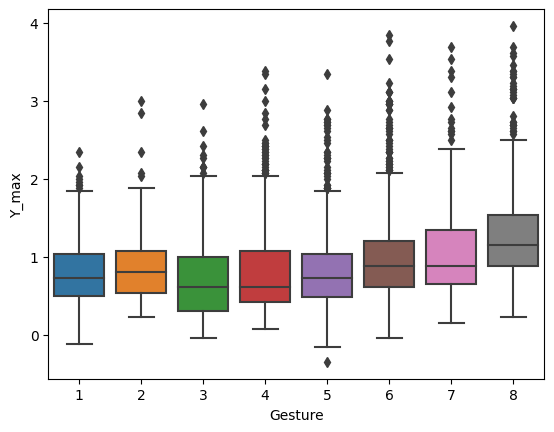

In [21]:
sns.boxplot(x='Gesture', y='Y_max', data=df_feats)

<Axes: xlabel='Gesture', ylabel='Z_max'>

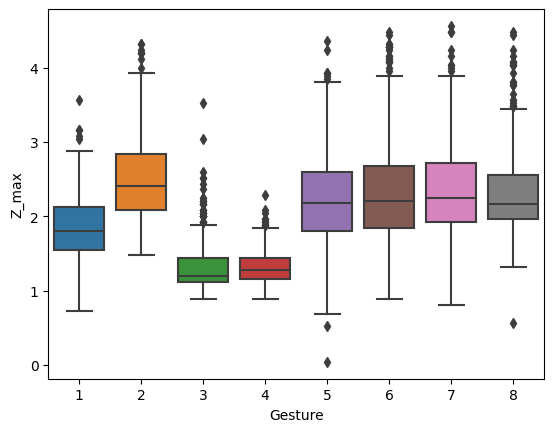

In [22]:
sns.boxplot(x='Gesture', y='Z_max', data=df_feats)

Outliers: X_max > 3, Y_max > 3.5

<Axes: xlabel='Gesture', ylabel='X_min'>

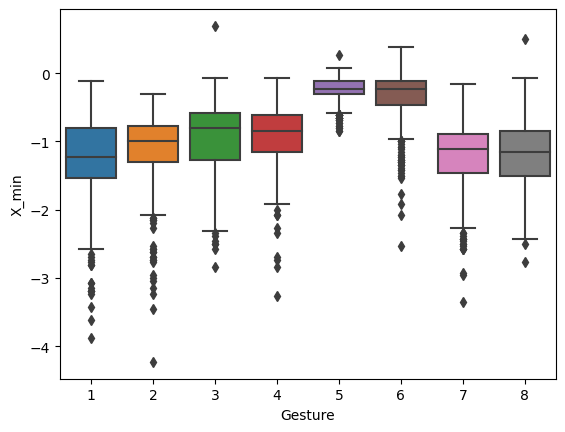

In [23]:
sns.boxplot(x='Gesture', y='X_min', data=df_feats)

<Axes: xlabel='Gesture', ylabel='Y_min'>

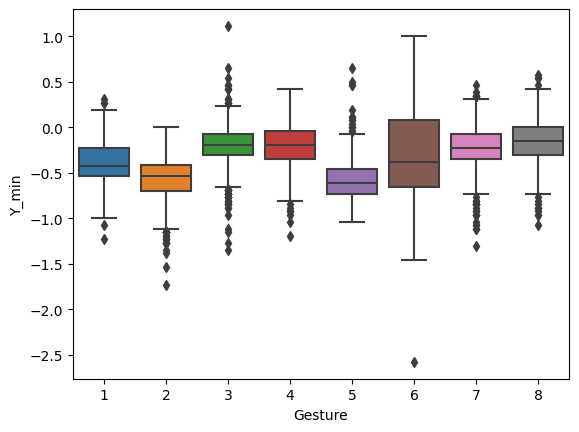

In [24]:
sns.boxplot(x='Gesture', y='Y_min', data=df_feats)

<Axes: xlabel='Gesture', ylabel='Z_min'>

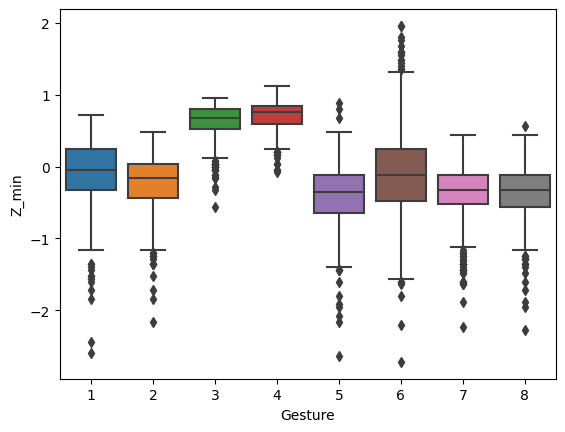

In [25]:
sns.boxplot(x='Gesture', y='Z_min', data=df_feats)

Outliers: X_min < 3.8, Y_min < 2, Z_min < 2.4

## Drop Outliers

In [26]:
df_feats = df_feats[(df_feats['X_mean'] < 0.8) & (df_feats['Y_mean'] < 1.5) & (df_feats['Z_mean'] < 1.6) & 
                    (df_feats['X_max'] < 3) & (df_feats['Y_max'] < 3.5) & 
                    (df_feats['X_min'] > -3.8) & (df_feats['Y_min'] > -2.5) & (df_feats['Z_min'] > -2.4)]

## Modeling

In [27]:
df_feats['Gesture'] = df_feats['Gesture'].astype('int')

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [29]:
X = df_feats.drop(['User','Day','Gesture','Repetition'], axis=1)
y = df_feats['Gesture']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
logreg = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial', max_iter=3000))
rfc = RandomForestClassifier(n_estimators=100)

In [31]:
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           1       0.64      0.71      0.67       118
           2       0.77      0.83      0.80       111
           3       0.57      0.61      0.59        96
           4       0.74      0.65      0.69       124
           5       0.64      0.69      0.66        99
           6       0.67      0.57      0.62       101
           7       0.55      0.55      0.55       119
           8       0.64      0.61      0.62       114

    accuracy                           0.65       882
   macro avg       0.65      0.65      0.65       882
weighted avg       0.65      0.65      0.65       882



In [33]:
# on training data
accuracy_score(y_train, logreg.predict(X_train)) #Underfitting

0.7213393870601589

In [34]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           1       0.75      0.83      0.79       118
           2       0.82      0.84      0.83       111
           3       0.72      0.86      0.79        96
           4       0.91      0.73      0.81       124
           5       0.84      0.88      0.86        99
           6       0.87      0.82      0.85       101
           7       0.81      0.71      0.76       119
           8       0.79      0.83      0.81       114

    accuracy                           0.81       882
   macro avg       0.81      0.81      0.81       882
weighted avg       0.82      0.81      0.81       882



In [35]:
# on training data
accuracy_score(y_train, rfc.predict(X_train))

1.0

## Random Forest outperforms Logistic Regression significantly